# PriorVAE, using only the decoder + MMD

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from reusable.kernels import esq_kernel
from jax import random
import dill

import jax.numpy as jnp
#path = "./learnt_models/05_args_more_comparisons.dill" # comparing sum of RBFs with terms <1, and experiments with ls of RQ around alpha = 0.1, 0.5
#path = "./learnt_models/05_args_larger_batches.dill" # note same as below.
path = "./learnt_models/05_args_incomplete_array.dill" # batch size 150 (same as more_comps), original set of kernels to compare: RBFs, sum of RBFs, RQ with fixed LS, varied scale

with open(path, "rb") as f:
    args = dill.load(f)

print(args["loss_functions"])
from reusable.util import decoder_filename
print(decoder_filename("05", args, suffix=args["loss_functions"][0]+"_metrics_hist"))


['MMD_rbf_0.5', 'MMD_rbf_1', 'MMD_rbf_2', 'MMD_rbf_8', 'MMD_rbf_16', 'MMD_rbf_ls_1_2_4_16_32', 'MMD_rqk_1_0.25', 'MMD_rqk_1_0.5', 'MMD_rqk_1_1', 'MMD_rqk_1_8', 'MMD_rqk_1_16', 'MMD_rqk_4_0.25', 'MMD_rqk_4_0.25', 'MMD_rqk_4_1', 'MMD_rqk_4_8', 'MMD_rqk_4_16']
05_35_32_30_0.1_150_0.0001_400_100MMD_rbf_0.5_metrics_hist


/home/max/4yp/plotting/plots.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


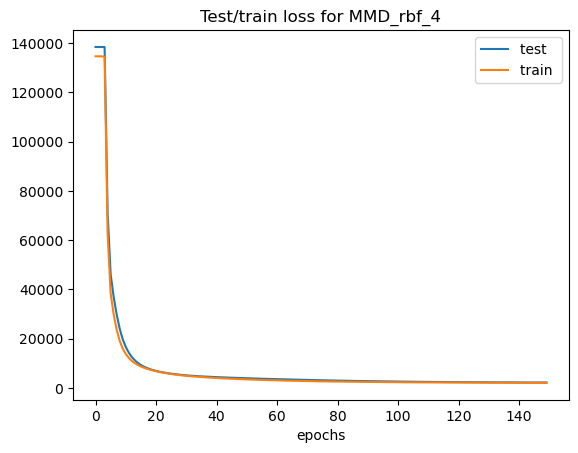

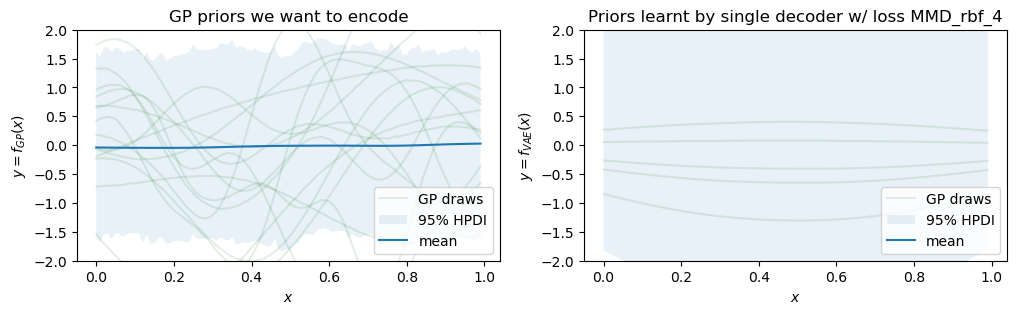

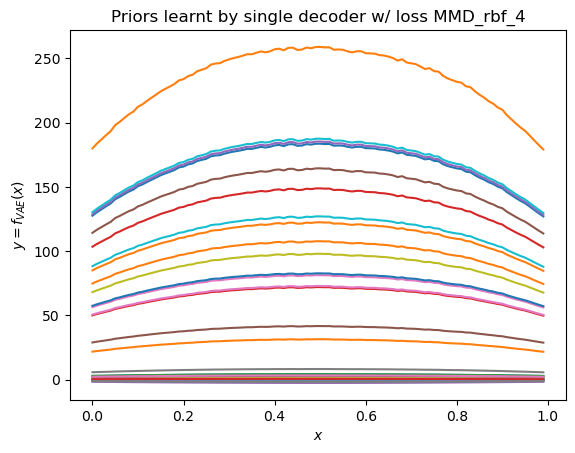

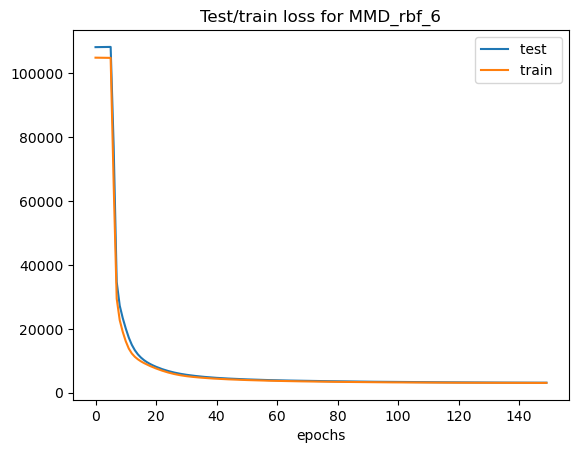

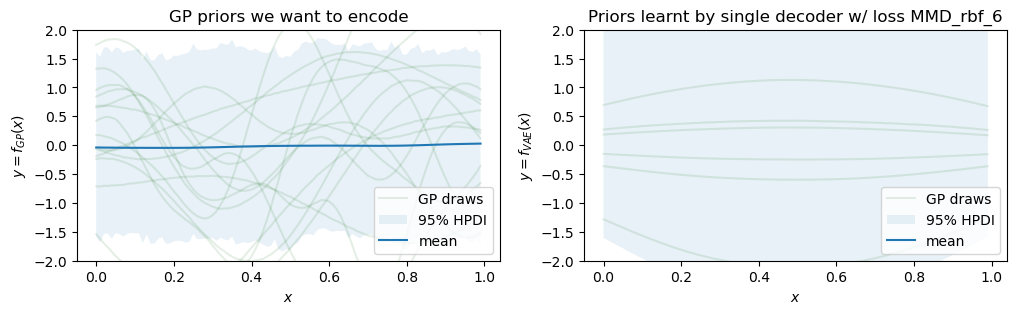

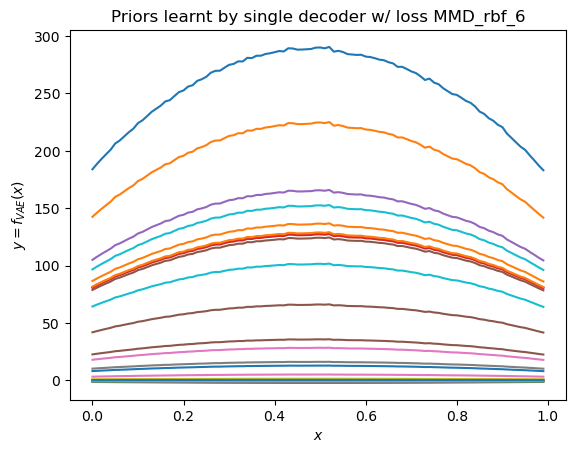

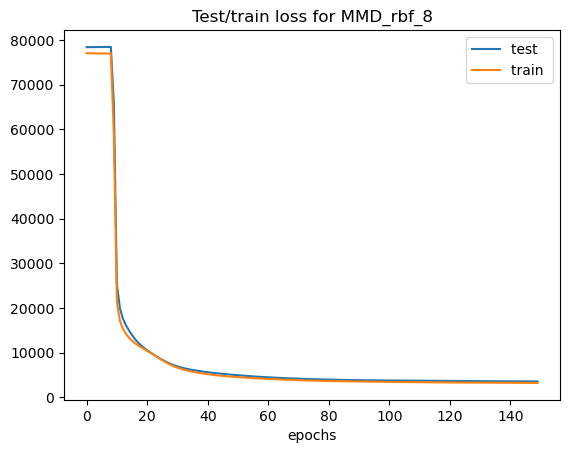

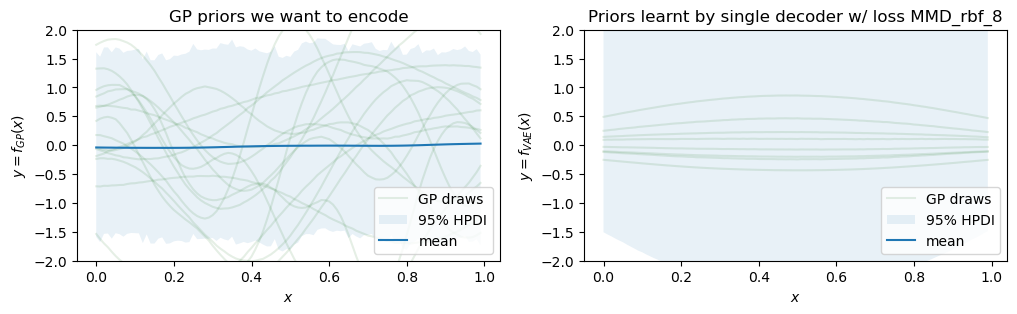

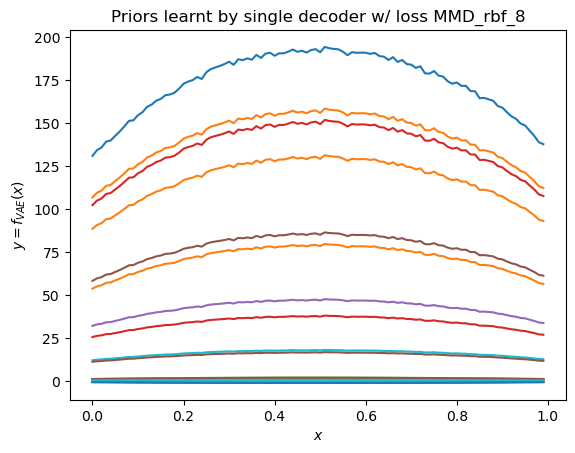

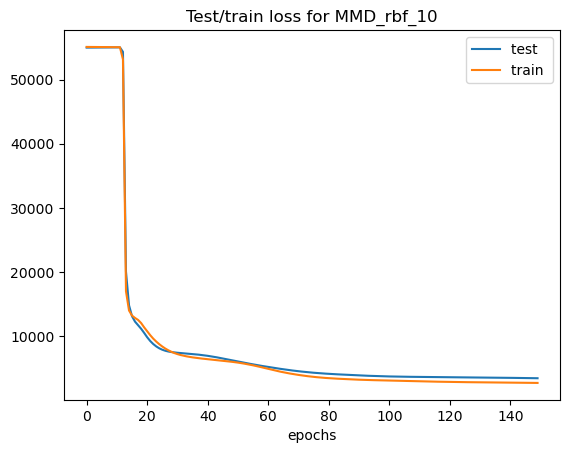

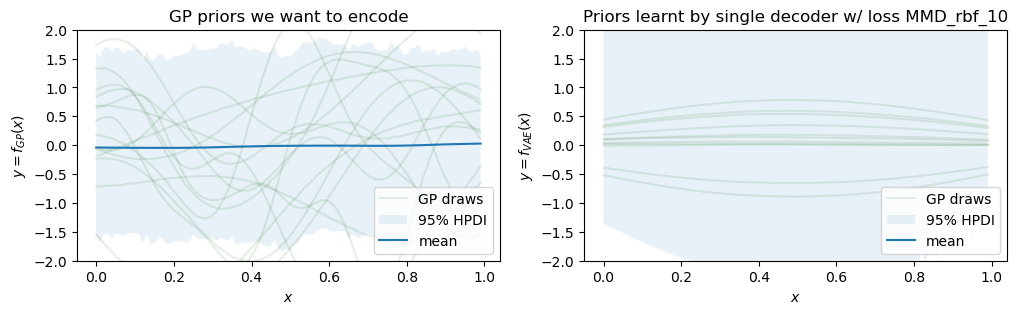

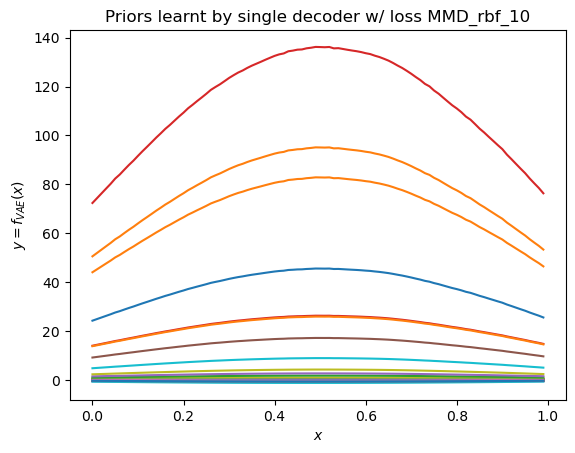

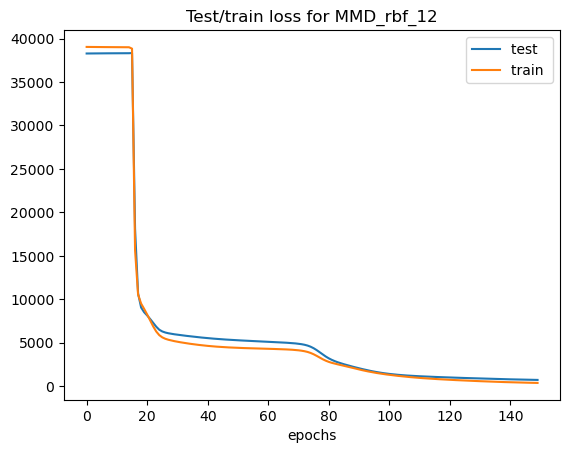

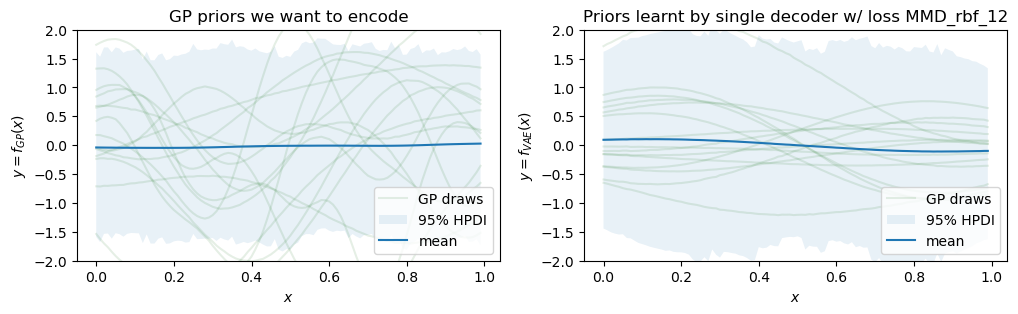

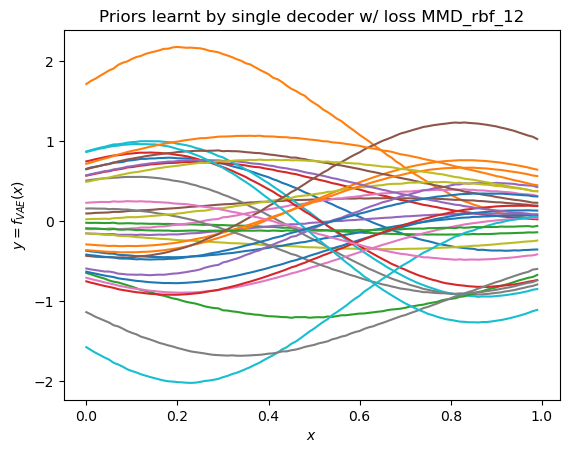

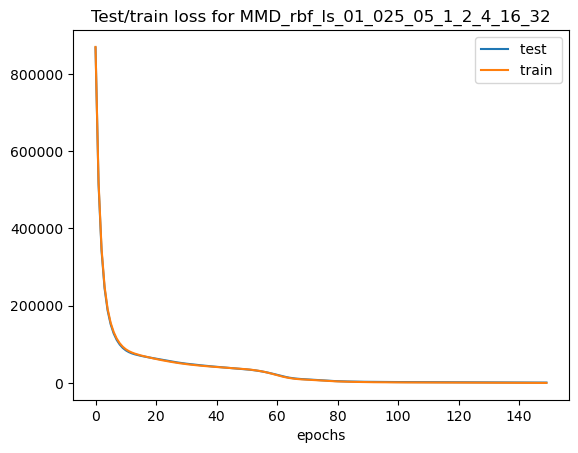

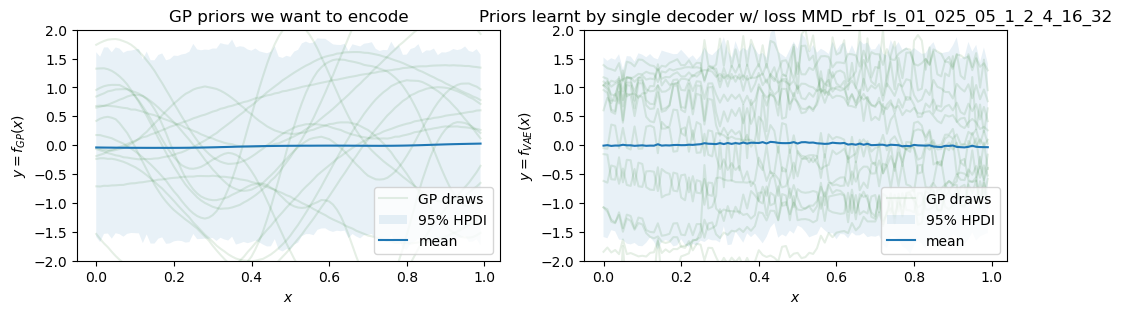

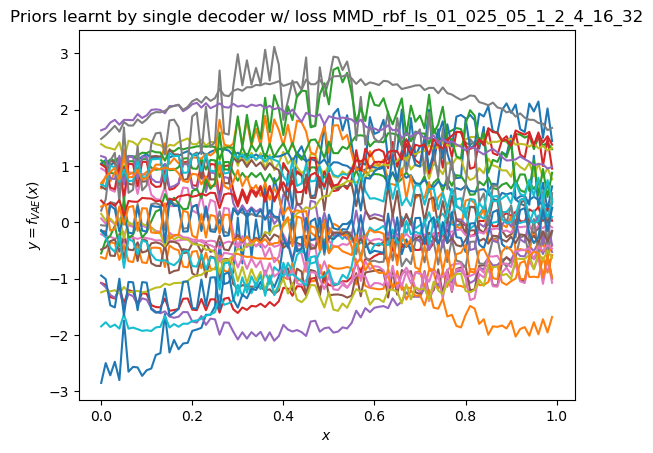

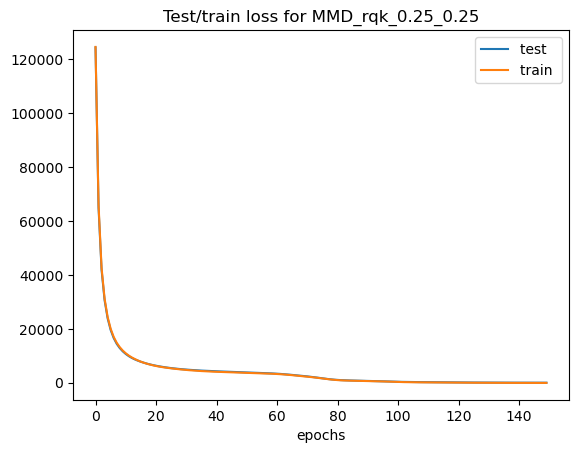

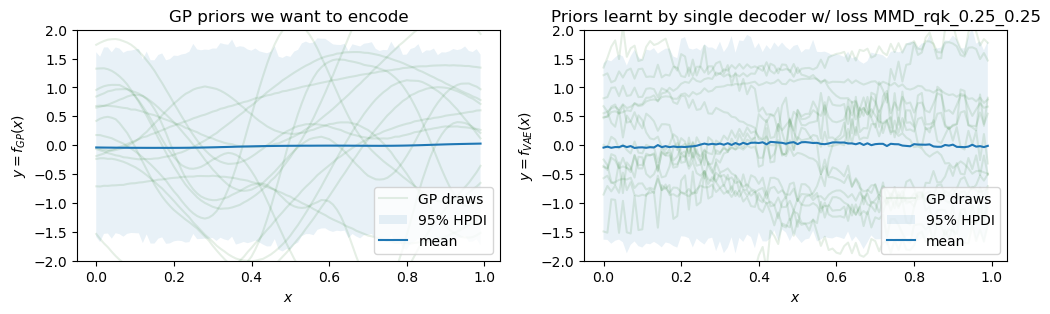

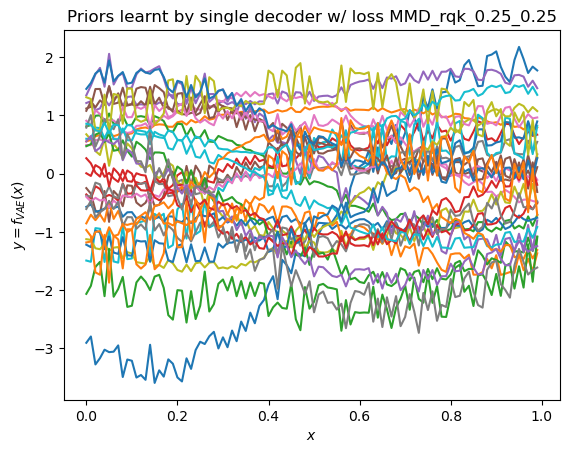

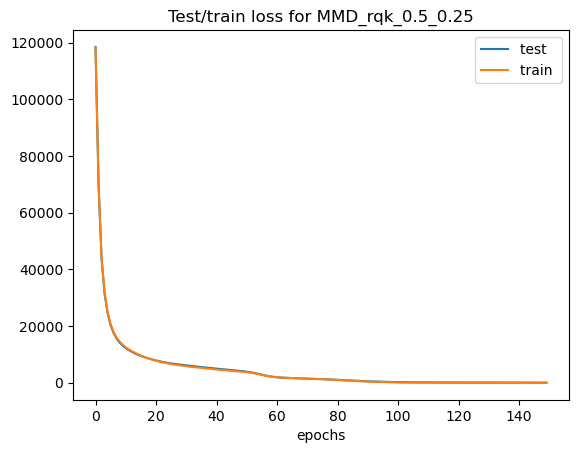

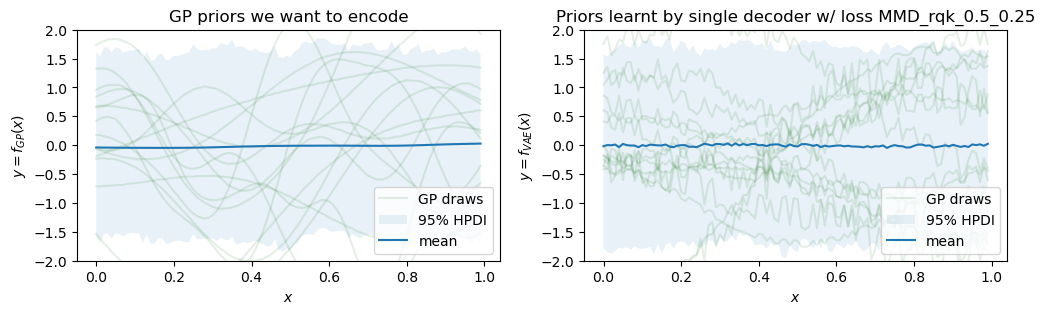

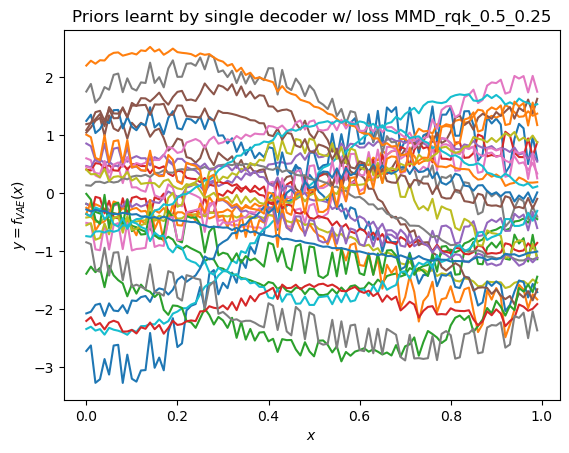

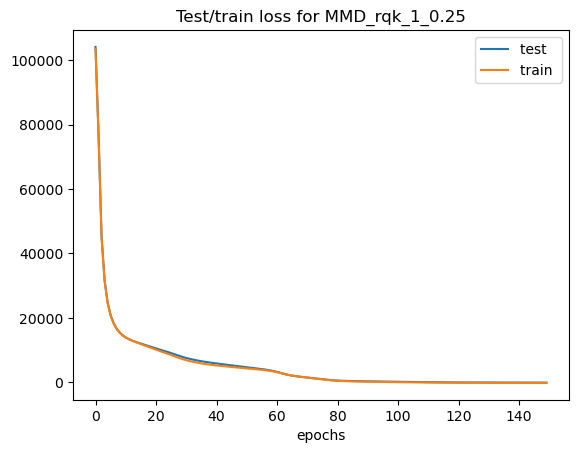

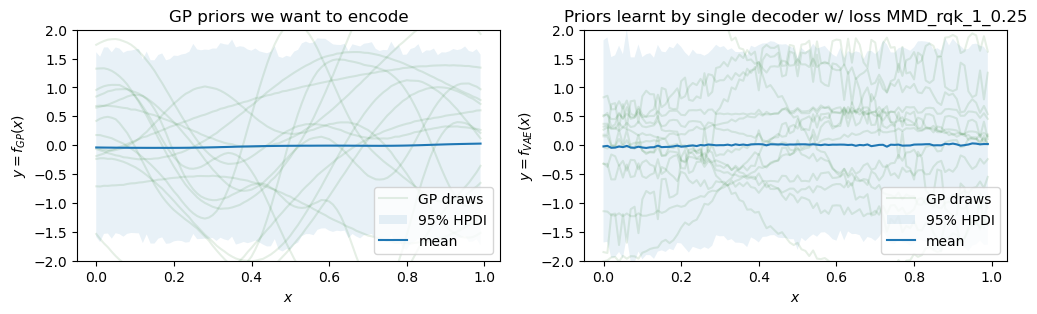

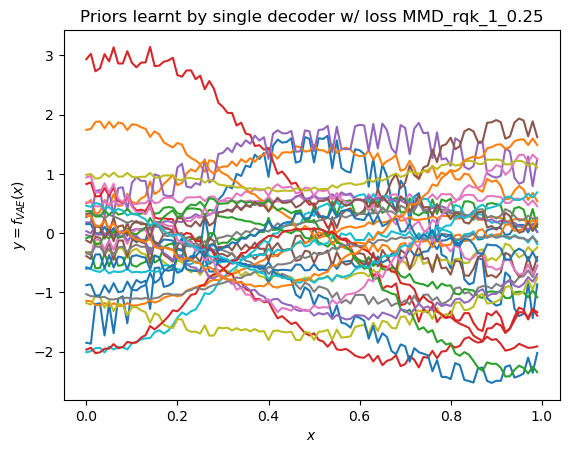

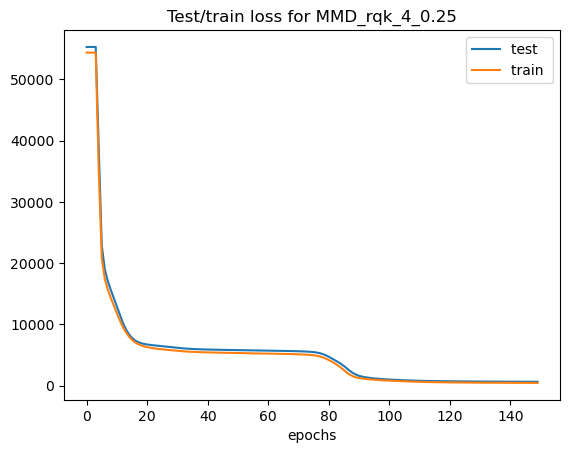

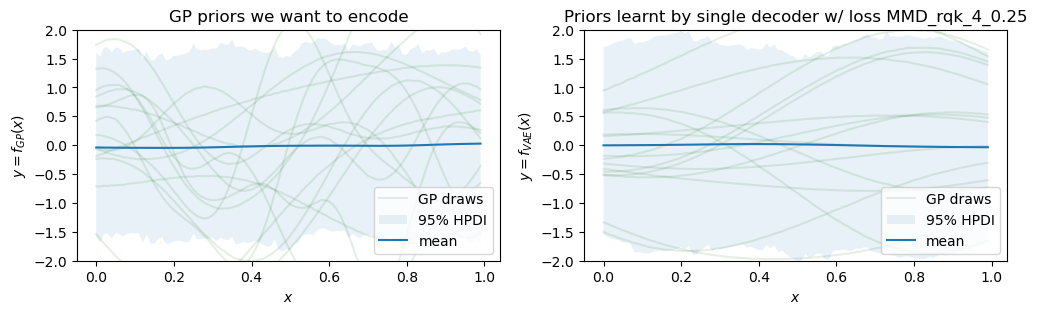

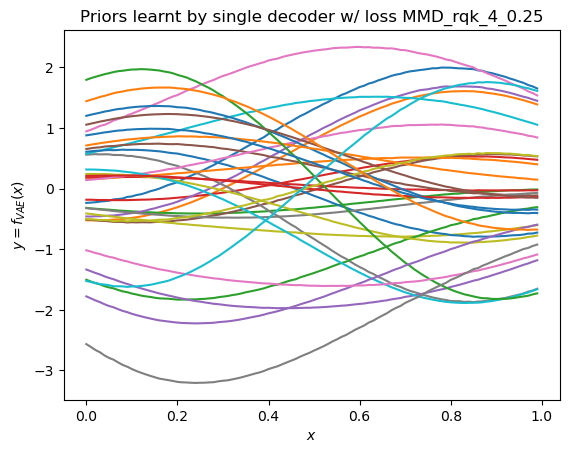

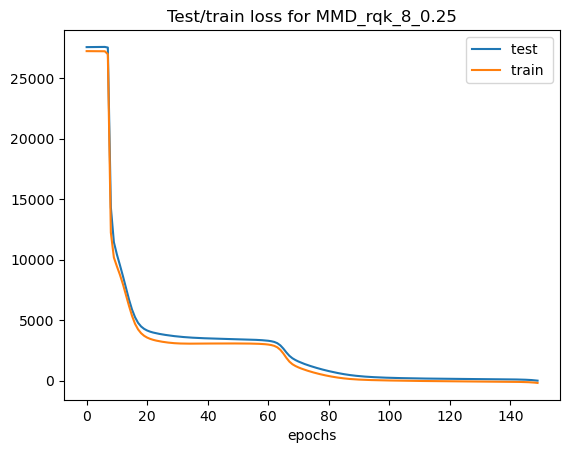

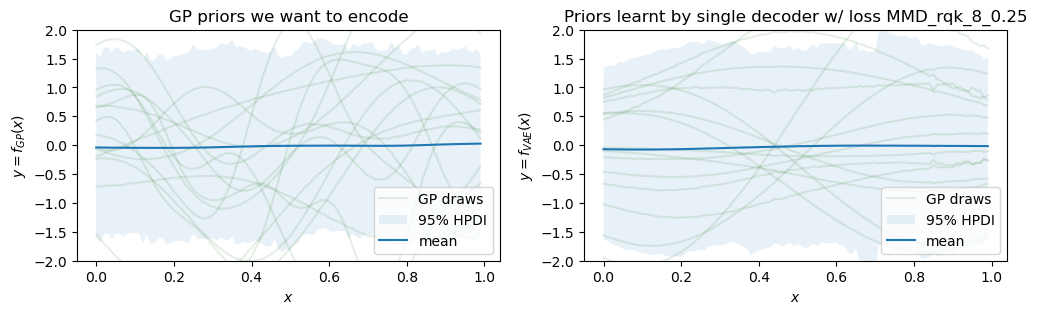

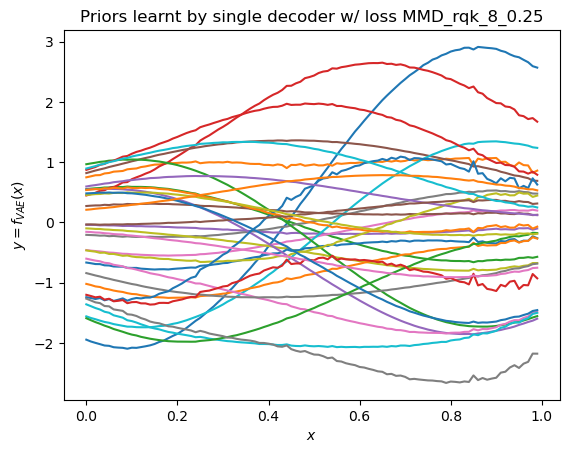

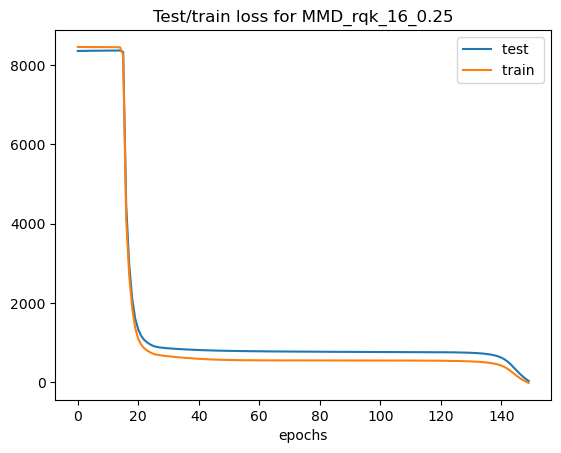

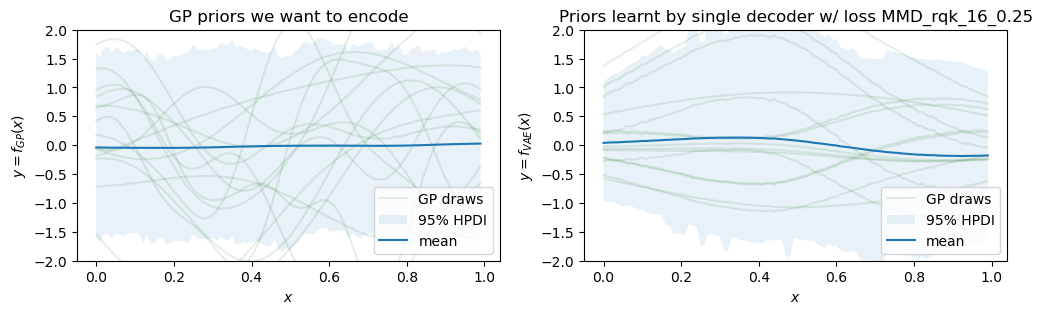

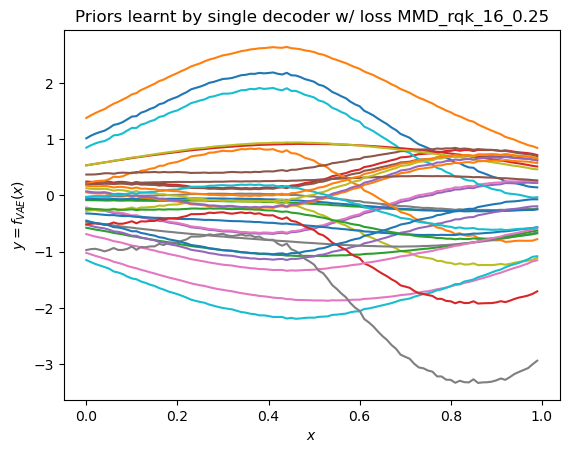

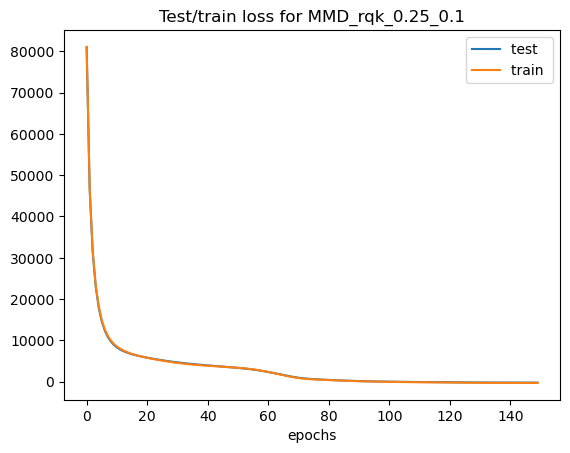

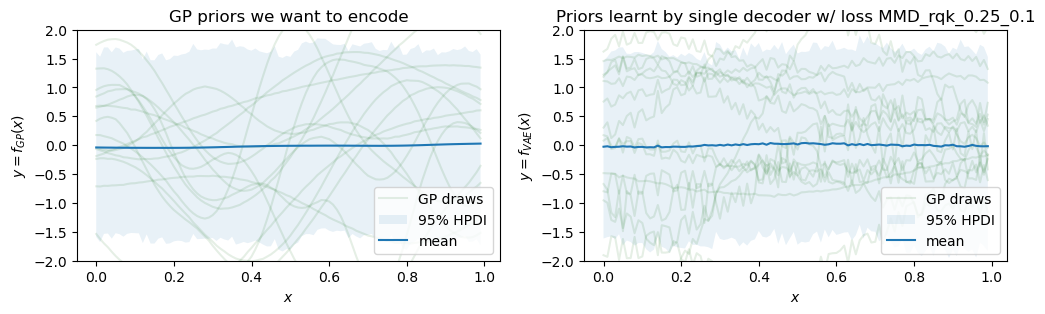

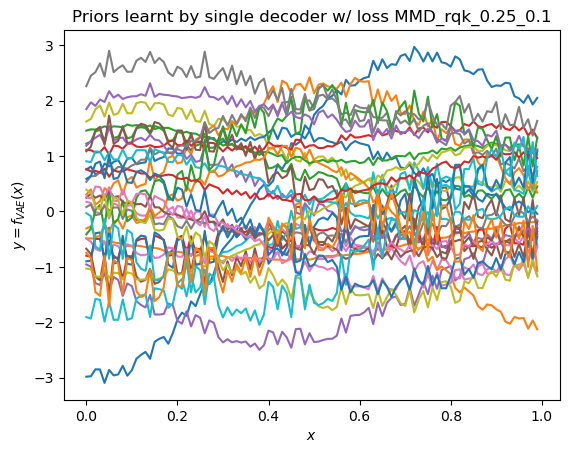

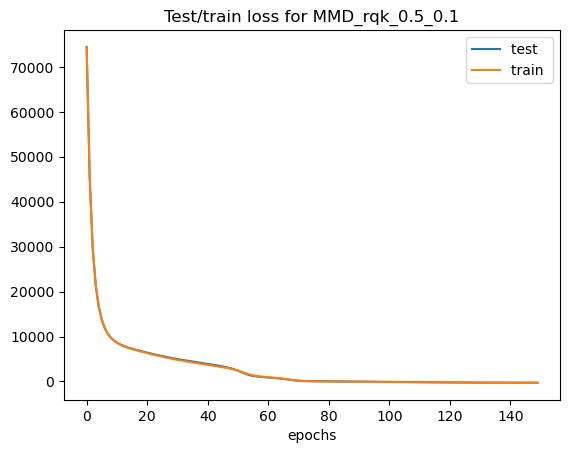

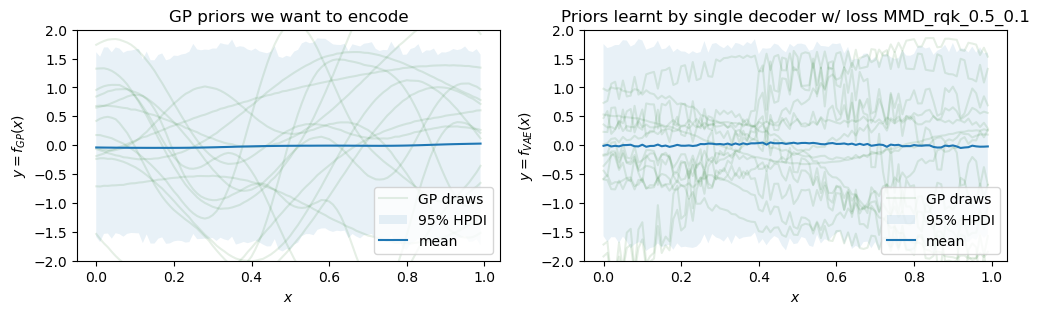

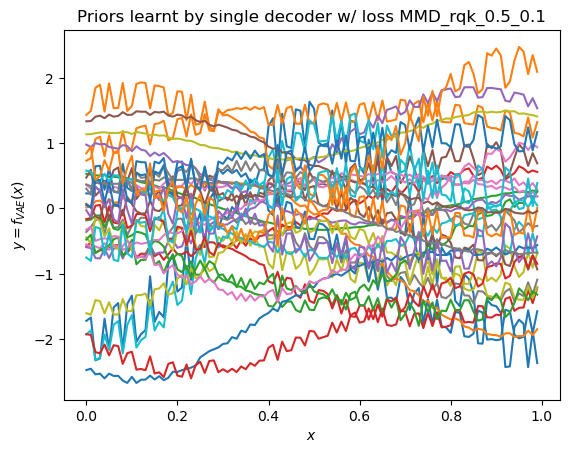

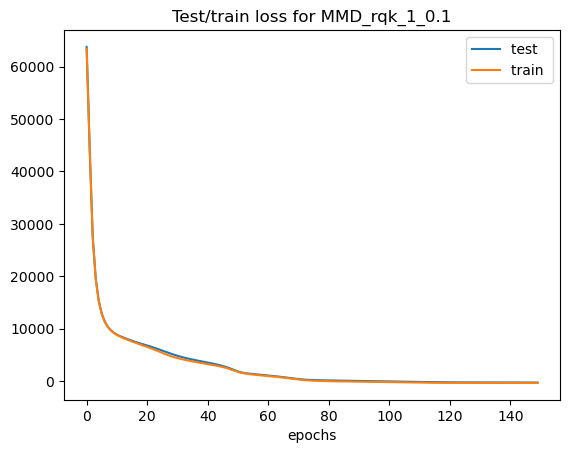

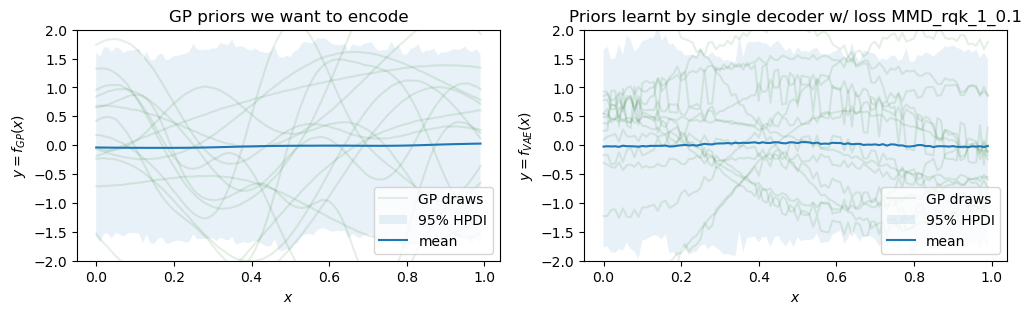

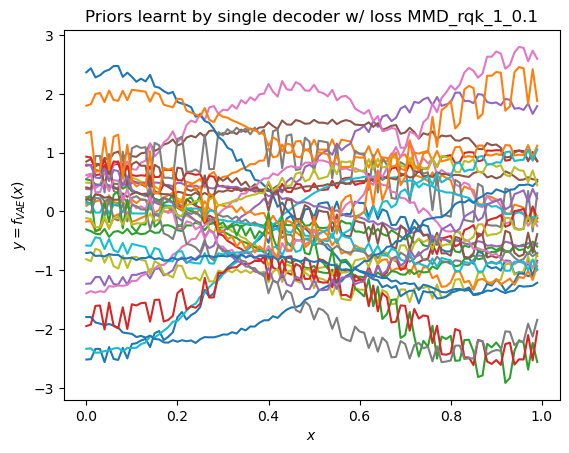

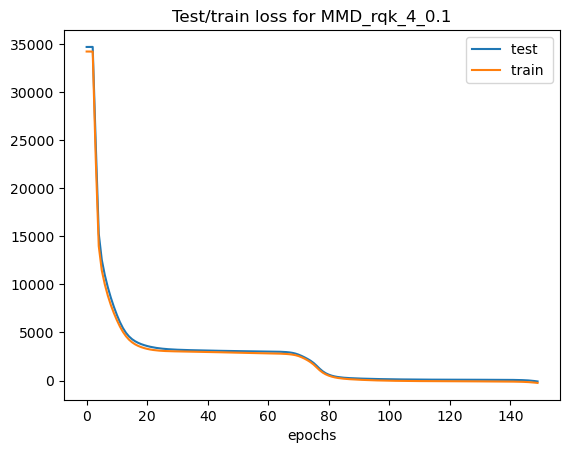

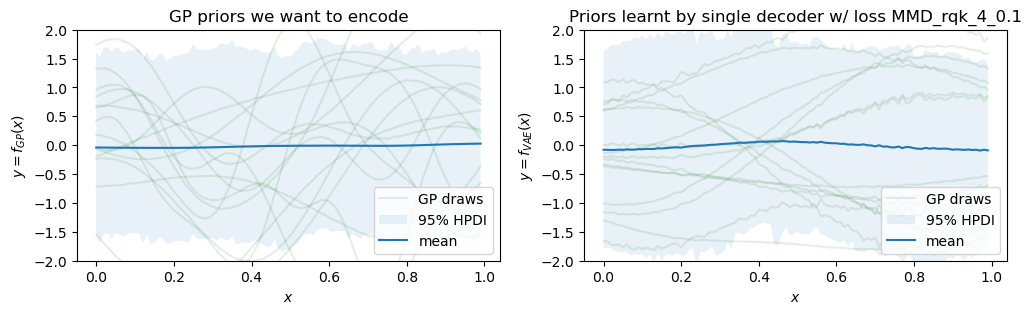

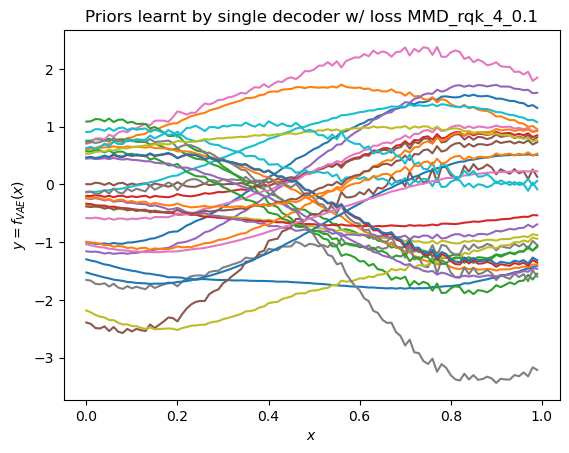

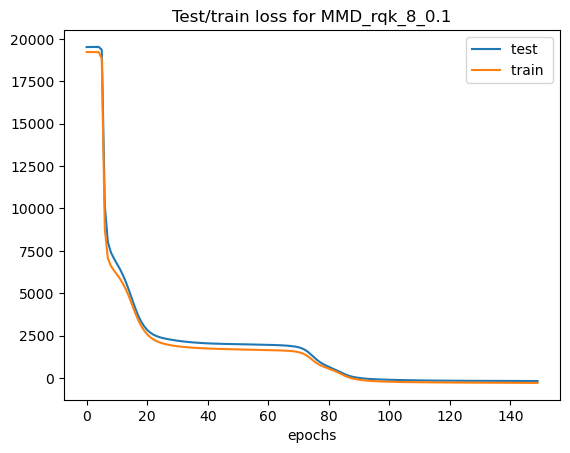

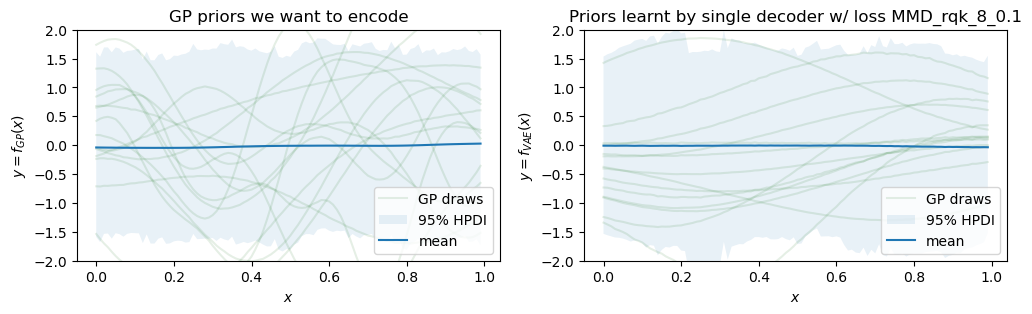

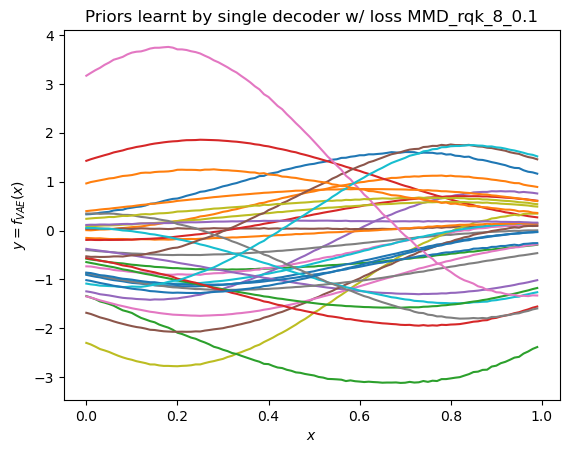

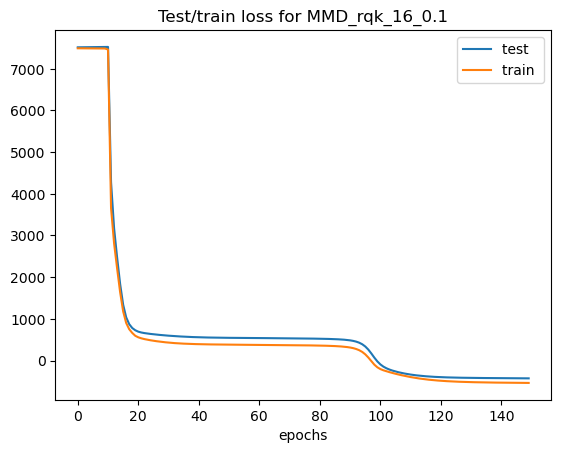

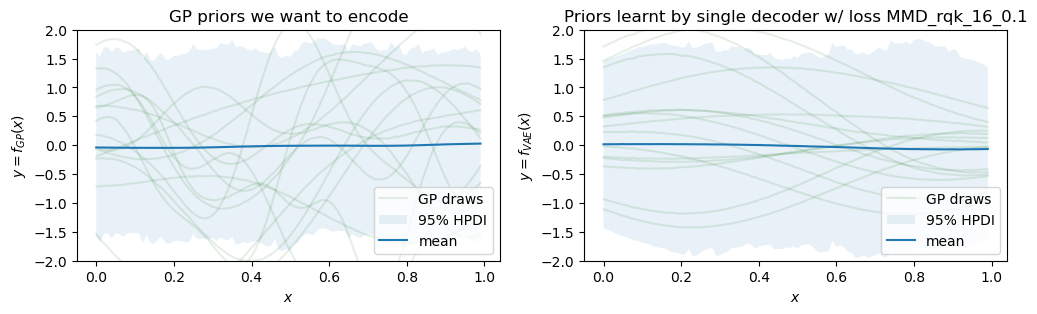

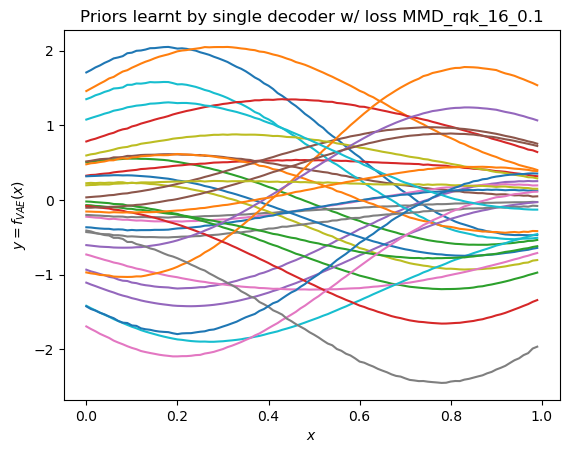

In [7]:
from reusable.vae import Single_Decoder
from numpyro.infer import Predictive

from reusable.gp import OneDGP
from reusable.vae import decoder_sample
from reusable.util import get_savepath, decoder_filename
from plotting.plots import plot_draws, compare_draws, plot_training

from flax import serialization


rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']



for loss_fn in args["loss_functions"]:
    file_path = f'{get_savepath()}/{decoder_filename("05", args, suffix=loss_fn+"_metrics_hist")}'

    try:
        with open(file_path, 'rb') as file:
            metrics_history = dill.load(file)
    except FileNotFoundError: 
        print(f"failed to load data for loss fn {loss_fn}, path {file_path}")
        continue


    plot_training(
            metrics_history["test_loss"] ,
            metrics_history["train_loss"],
            f"Test/train loss for " + loss_fn,
            
            
        )

    dummy_decoder = Single_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"]+args["n"],)))
    file_path = f'{get_savepath()}/{decoder_filename("05", args, suffix=loss_fn)}'

    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

    plot_vae_predictive = Predictive(decoder_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]
          
    compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by single decoder w/ loss " + loss_fn, '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$')

    plot_draws(vae_draws,args["x"], "Priors learnt by single decoder w/ loss " + loss_fn, '$y=f_{VAE}(x)$')
    

        